# Findings 1 
## Week 7 (03.03.2025)

# imports

In [2]:
import sys
import os
import numpy as np

# Get the notebook's current directory
notebook_dir = os.getcwd()

# Move one level up to get the parent directory
parent_dir = os.path.dirname(notebook_dir)

# Add the parent directory to sys.path
sys.path.append(parent_dir)

from module import *

/opt/anaconda3/envs/cqr/lib/python3.11/site-packages/do_mpc/sysid/__init__.py:15: UserWarning: The ONNX feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The ONNX feature is not available. Please install the full version of do-mpc to access this feature.')
/opt/anaconda3/envs/cqr/lib/python3.11/site-packages/do_mpc/opcua/__init__.py:14: UserWarning: The opcua feature is not available. Please install the full version of do-mpc to access this feature.
  warnings.warn('The opcua feature is not available. Please install the full version of do-mpc to access this feature.')


# system init
This is a generic spring damper setup. Very simple and linear, with two states and one input. The state euation is the force balance of a spring damper.

In [3]:
spring_system = SpringSystem(set_seed=0)

In [4]:
default_device = 'cpu'

Modifying constraints

In [5]:
#spring_system.lbu = np.array([-10])       # [lower_bound_f_ext]
#spring_system.ubu = np.array([10])        # [upper_bound_f_ext]

# surrogate generator init
This class is designed to be totally generic, i.e., it can take any do-mpc model, or at least that is the idea.

In [6]:
dm = DataManager(set_seed=0)

# random data

Here we generate sampled with one random initial point and random inputs. Then the data and the data is split randomly to feed different parts of the algorithm.
There is another alternate algorithm which generates data by chasing random setpoints with the help of an MPC controller.

In [ ]:
dm.random_input_sampler(system = spring_system, n_samples=10000)
#dm.data_splitter(order=3, cqr_calibration=0.001, test=0.001, narx_train=0.998, cqr_train=0.998)
dm.data_splitter(order=2)

Generating data:  61%|██████    | 605736/1000000 [26:36<18:26, 356.36it/s]    

## data visualisation

/Users/sourjyanaskar/Library/CloudStorage/OneDrive-Personal/tu_d/Thesis/nmpc_cqr_gpu_thesis/module/_graphics.py:63: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()


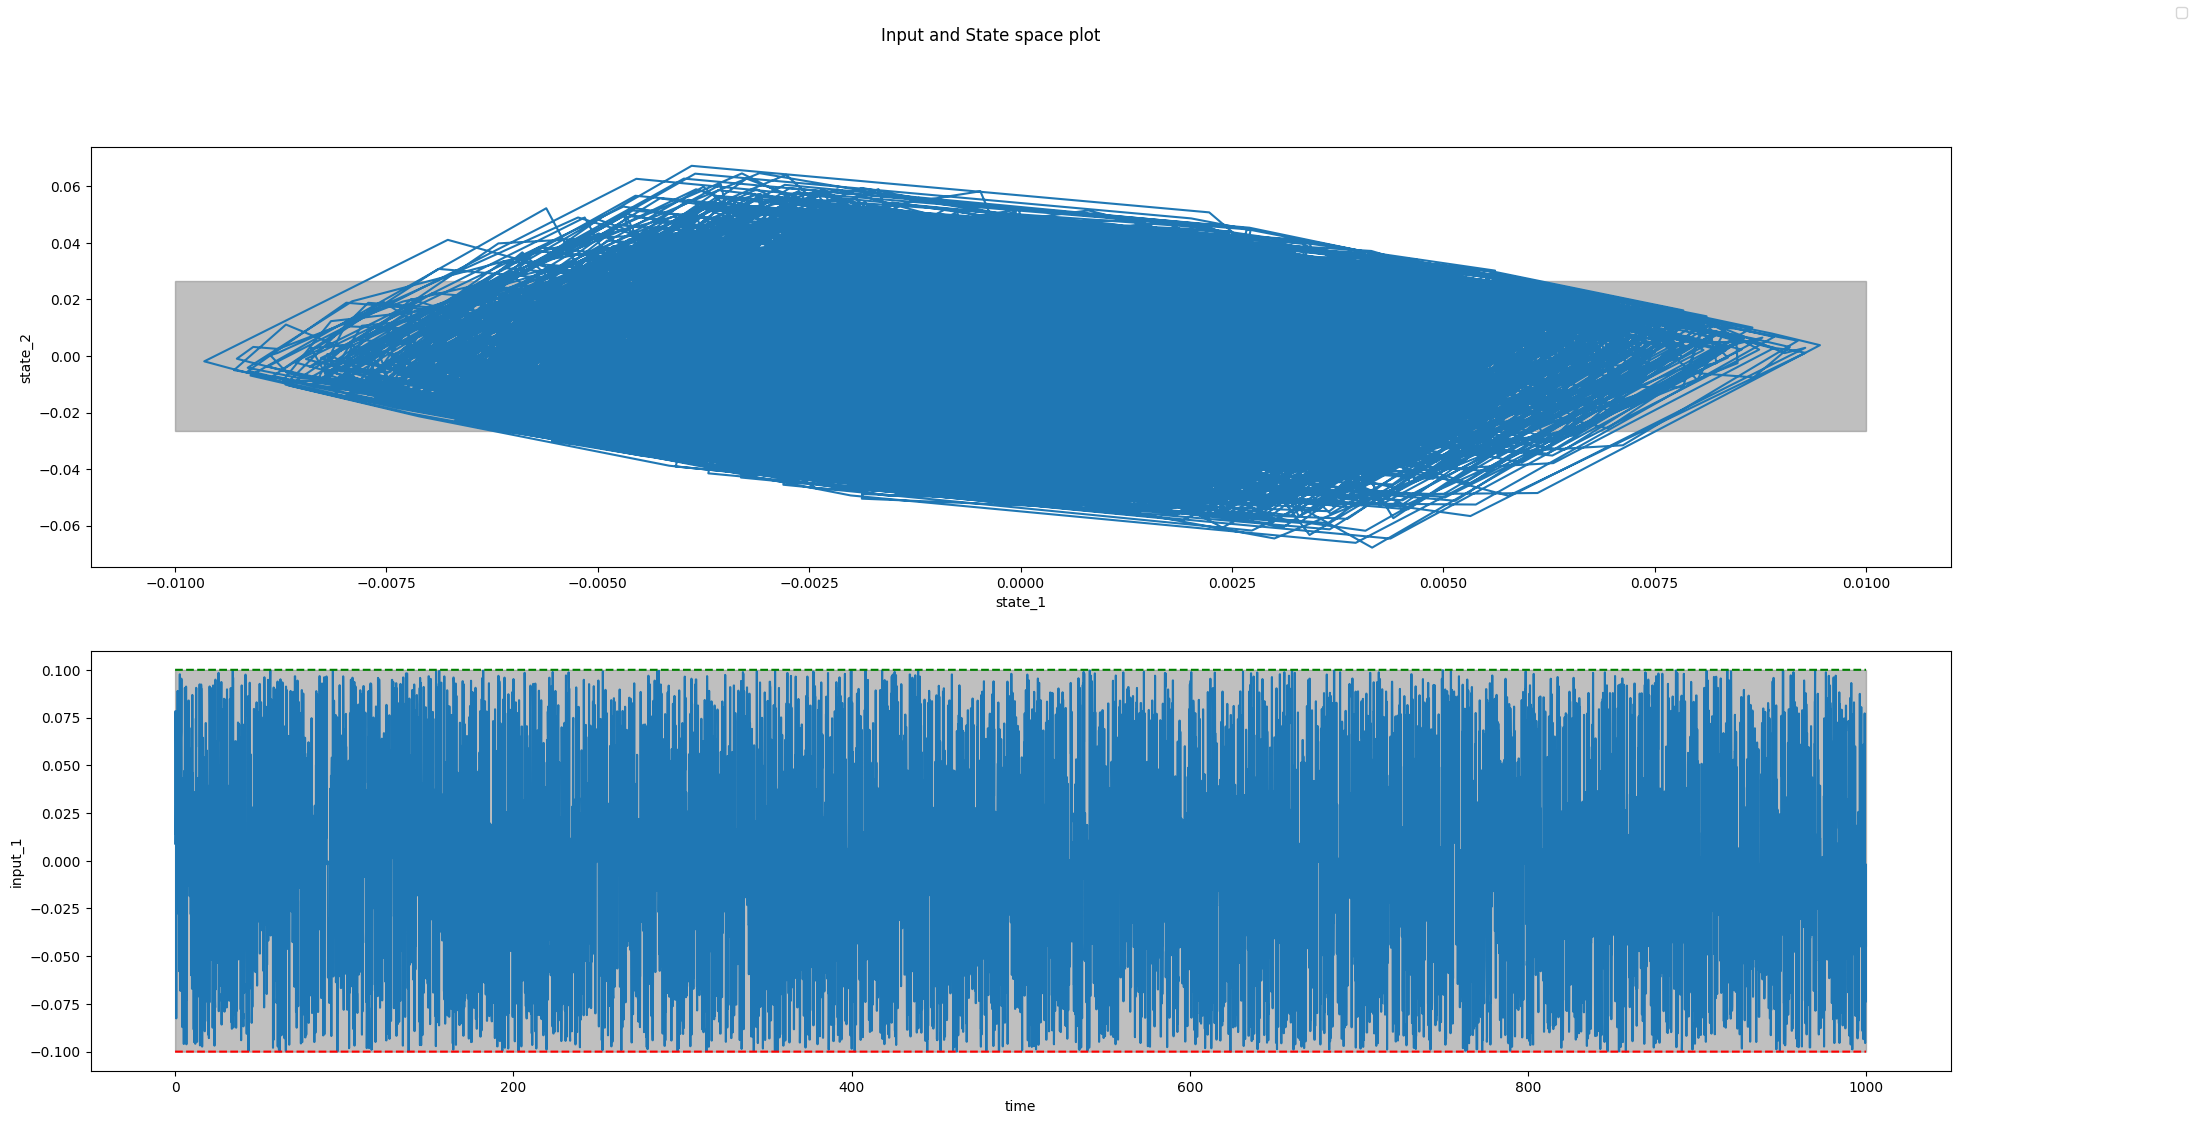

In [ ]:
dm.visualize2d_data()

/Users/sourjyanaskar/Library/CloudStorage/OneDrive-Personal/tu_d/Thesis/nmpc_cqr_gpu_thesis/module/_graphics.py:124: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  fig.legend()


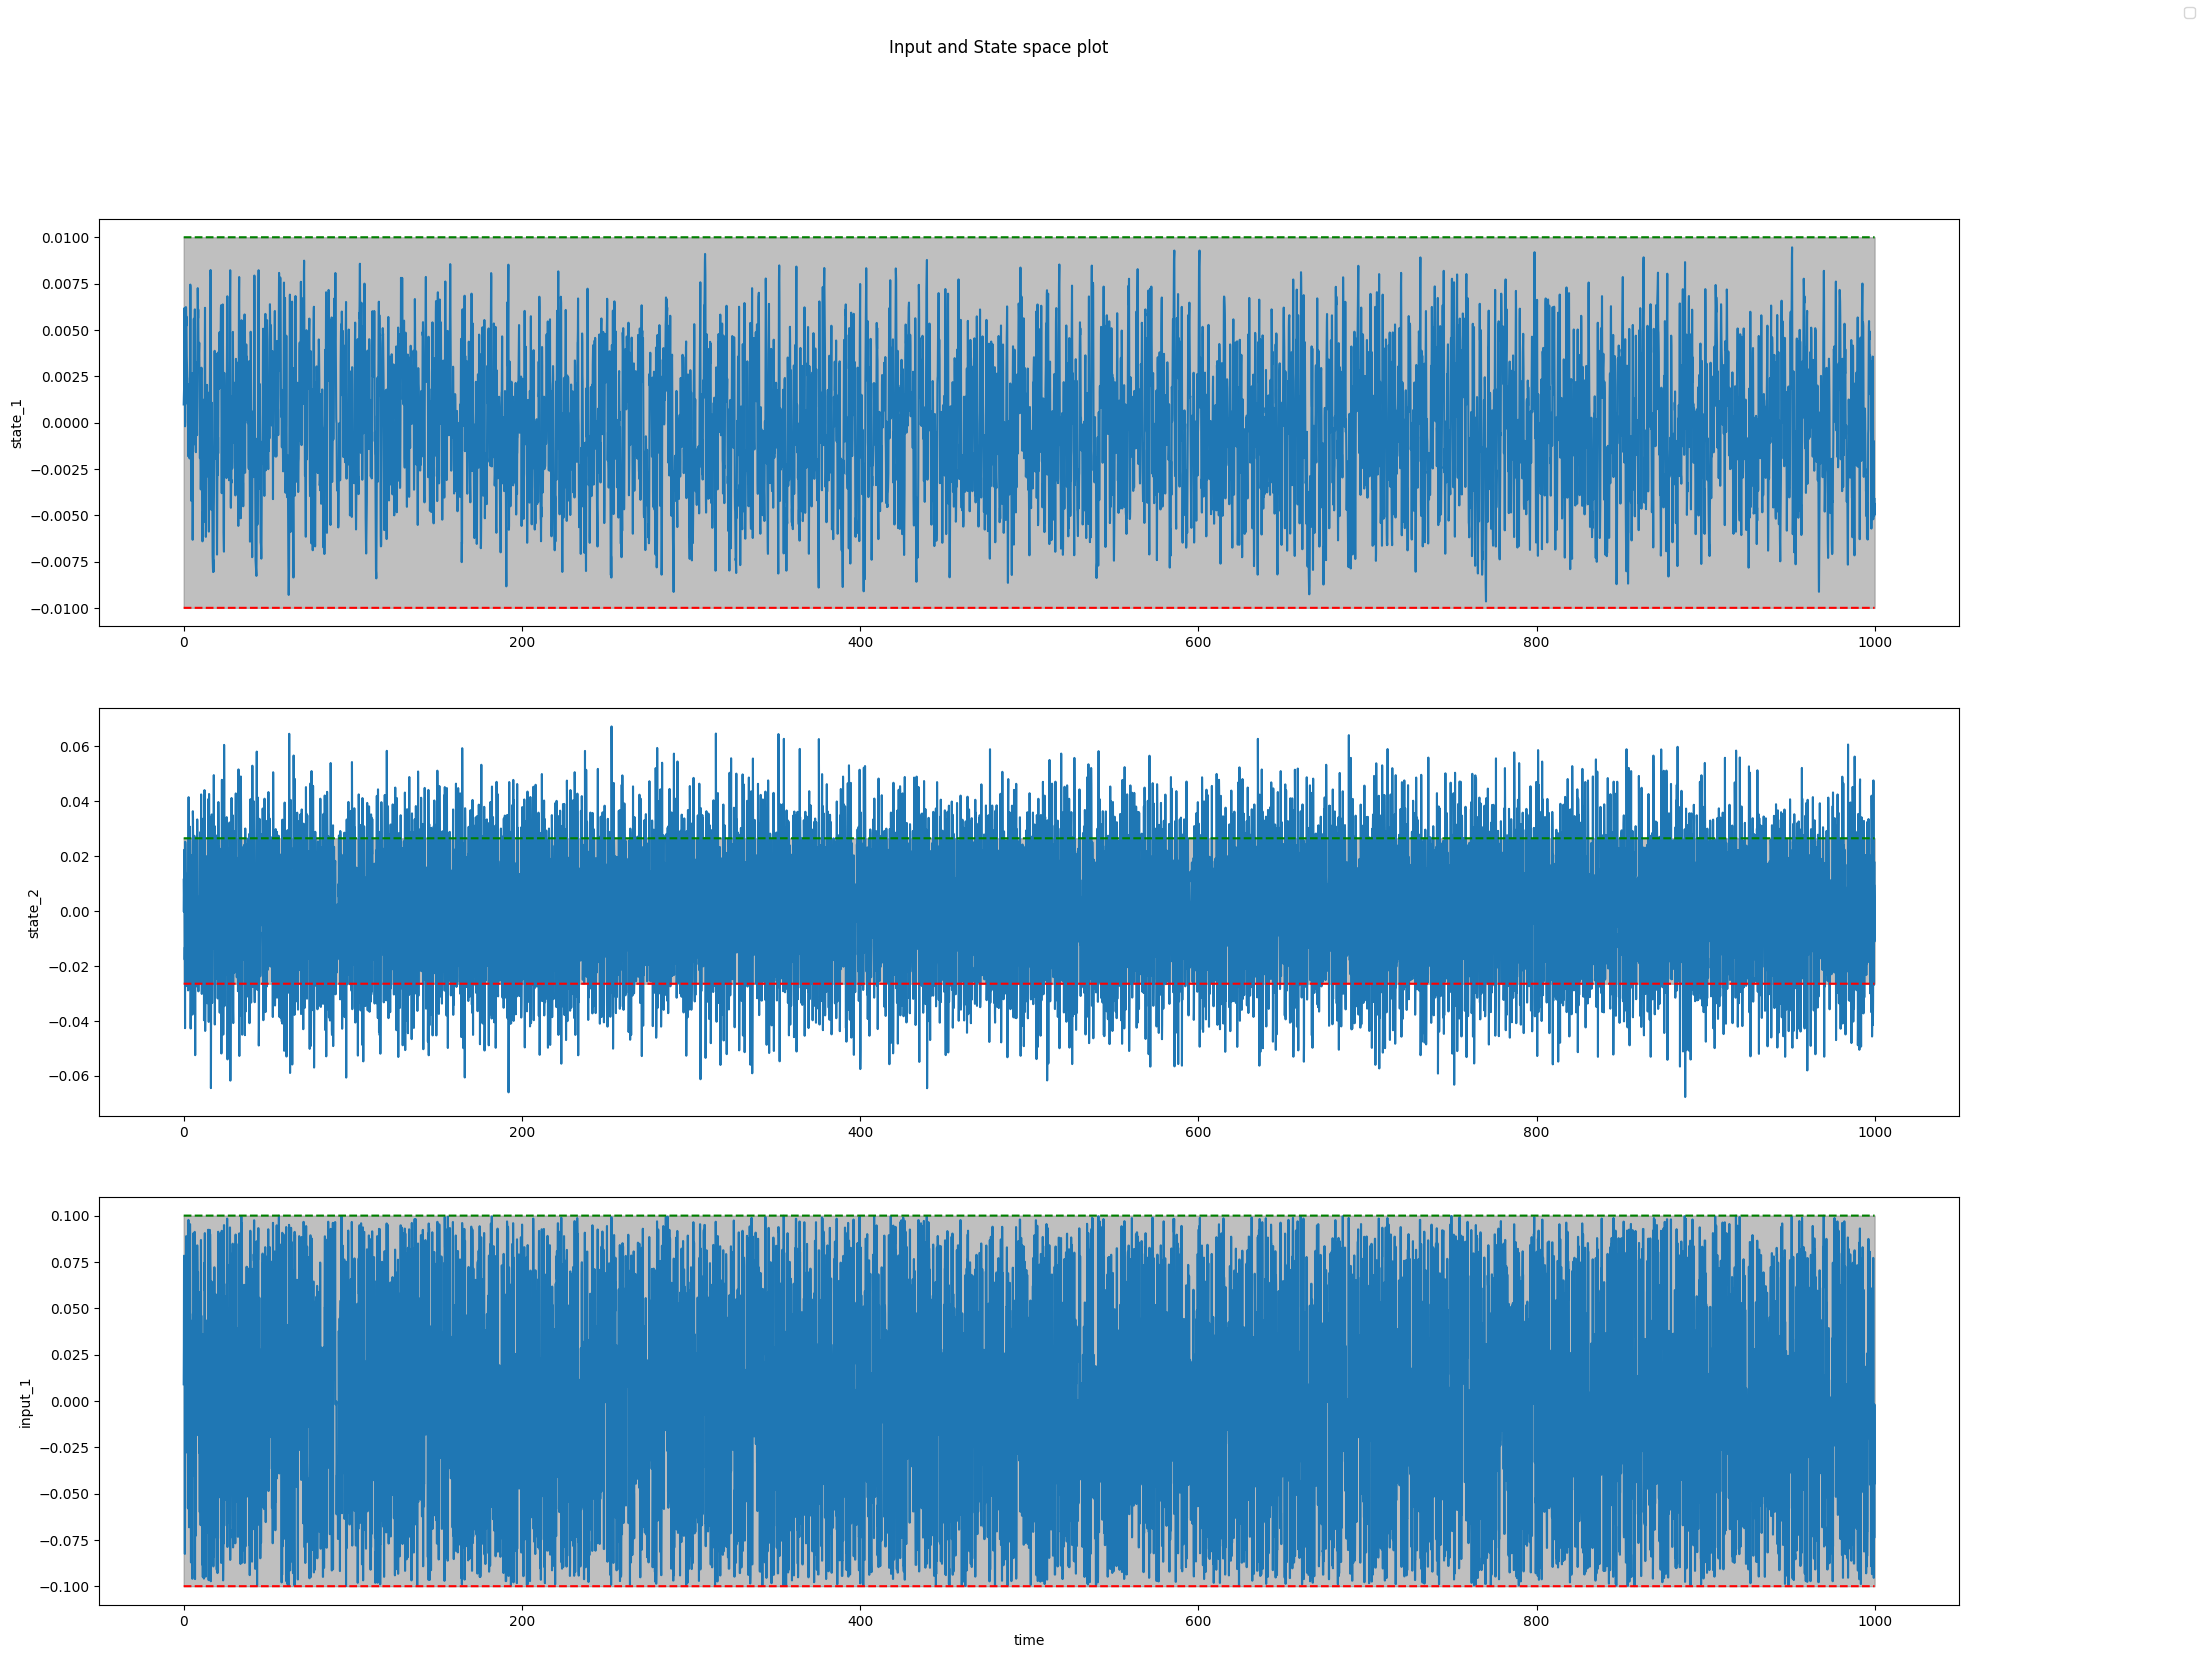

In [ ]:
dm.visualize_data()

# NARX model

In [ ]:
dm.narx_trainer(hidden_layers=[1000], batch_size=1000,
          learning_rate=0.1, epochs= 10000, scheduler_flag=True, device=default_device)
dm.narx.plot_narx_training_history_plotly()

Training NARX: 100%|██████████| 250/250 [00:07<00:00, 33.69it/s]


# quantile regression
Here qunatile regression is done to bound the errors with confidence values

In [ ]:
dm.train_individual_qr(alpha=0.1, hidden_layers=[2],  epochs= 10000, batch_size=1000, device=default_device)
dm.cqr.plot_qr_training_history()

Training Cqr q= 0.05: 100%|██████████| 250/250 [00:03<00:00, 80.67it/s]


This section visualises the quantile regression on the calibration data which the regressors has yet not seen.

In [ ]:
dm.cqr_plot_qr_error()

This plot is made against test data which till now is untouched.

In [ ]:
dm.plot_cqr_error_plotly()

# simulation

In [ ]:
dm.check_simulator(system=spring_system, iter= 50)

state_1_lag_1 <<--- @1=((state_1_lag_1--0.000122589)/0.00352367), @2=((state_2_lag_1--0.000468091)/0.0228845), @3=((state_1_lag_2--9.18993e-05)/0.00353787), @4=((state_2_lag_2-7.97144e-05)/0.0226143), @5=((input_1_lag_0--0.00242705)/0.0579884), @6=((input_1_lag_1--0.00115011)/0.0581787), @7=(((((((-0.0331454*@1)+(-0.058879*@2))+(0.226634*@3))+(-0.0532342*@4))+(0.00555249*@5))+(0.0602474*@6))+0.313893), @8=(((((((0.204949*@1)+(0.0198537*@2))+(0.0206903*@3))+(0.13925*@4))+(0.116019*@5))+(0.135125*@6))+0.0556129), @9=(((((((0.00757215*@1)+(0.0932517*@2))+(0.0671292*@3))+(0.146849*@4))+(0.107366*@5))+(-0.0467257*@6))+0.0420786), @10=(((((((-0.054574*@1)+(0.0352536*@2))+(-0.268243*@3))+(0.119603*@4))+(0.0192181*@5))+(-0.12966*@6))+-0.0868477), @11=(((((((0.0181426*@1)+(-0.0820137*@2))+(-0.112428*@3))+(0.0148523*@4))+(-0.0454551*@5))+(-0.00718915*@6))+-0.291569), @12=(((((((-0.0443595*@1)+(0.0624581*@2))+(0.10052*@3))+(0.114706*@4))+(-0.092463*@5))+(-0.0301916*@6))+0.220226), @13=(((((((0.15